In [501]:
from platform import python_version

print(python_version())

from IPython.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.lines import Line2D
from matplotlib import cm
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Lipinski
from rdkit.Chem import AllChem

from mendeleev import element

#import chemcoord as cc
from scipy import stats
from rdkit import Chem
import seaborn as sns
import pandas as pd
import numpy as np
import shutil
import glob
import csv
import ast
import os
import re
from os.path import exists
import rmsd
from itertools import product
from itertools import combinations
import pickle
from periodictable import C,H,N,O,P,S
import scipy.stats as st

#sns.set_context('paper', font_scale=1.1)

## CHANGE FOR YOUR COMPUTER ##
comp_loc = '/Users/z5380625/Documents/Research/'

3.10.6


In [490]:
def read_geometry_from_xyz(file):
    '''Purpose: Read in molecular geometry from xyz file'''
    final_geometry = []
    with open(file,'r') as f:
        temp_lines = f.readlines()[2:]
        for i in np.arange(0,len(temp_lines),1):
            temp_split_line = temp_lines[i].split()
            split_line = [temp_split_line[0]]+[float(temp_split_line[j]) for j in np.arange(1,len(temp_split_line))]
            final_geometry.append(split_line)
    f.close()
    return final_geometry

In [491]:
def calculate_translated_coordinates(geometry):
    '''Purpose: Calculate centre of mass coordinates in Angstroms'''
    
    dict_masses = {'C':C.mass,'H':H.mass,'N':N.mass,'O':O.mass,'P':P.mass,'S':S.mass}
    mols = [line[0] for line in geometry]
    mol_masses = np.asarray([float(dict_masses[mol]) for mol in mols])*1.66054e-27
    
    # x centre of mass coordinate
    x_coords = np.asarray([float(line[1]) for line in geometry])
    x_cm = sum(x_coords*mol_masses)/sum(mol_masses)
    x_trans = x_coords - x_cm
    
    # y centre of mass coordinate
    y_coords = np.asarray([float(line[2]) for line in geometry])
    y_cm = sum(y_coords*mol_masses)/sum(mol_masses)
    y_trans = y_coords - y_cm
    
    # z centre of mass coordinate
    z_coords = np.asarray([float(line[3]) for line in geometry])
    z_cm = sum(z_coords*mol_masses)/sum(mol_masses)
    z_trans = z_coords - z_cm
    
    return x_trans*1e-10, y_trans*1e-10, z_trans*1e-10, mol_masses

In [492]:
def calculate_principle_moments(geometry):
    
    x_trans, y_trans, z_trans, mol_masses = calculate_translated_coordinates(geometry)
    
    # Ixx
    I_xx = sum(mol_masses*(y_trans**2+z_trans**2))
    
    # Iyy
    I_yy = sum(mol_masses*(z_trans**2+x_trans**2))
    
    # Izz
    I_zz = sum(mol_masses*(x_trans**2+y_trans**2))
    
    #Ixy = Iyx
    I_xy = -sum(mol_masses*x_trans*y_trans)
    
    #Iyz = Izy
    I_yz = -sum(mol_masses*y_trans*z_trans)
    
    #Izx = Ixz
    I_zx = -sum(mol_masses*z_trans*x_trans)
    
    
    # calculate principle moments of intertia
    
    inertia_matrix = np.array([[I_xx,I_xy,I_zx],[I_xy,I_yy,I_yz],[I_zx,I_yz,I_zz]])
    eig_vals = np.linalg.eigvalsh(inertia_matrix)
    
    I_a,I_b,I_c = eig_vals[0], eig_vals[1], eig_vals[2]
    
    return I_a,I_b,I_c

In [556]:
def calculate_rotational_constants(I_a,I_b,I_c):
    '''Purpose: Calculates the A, B, C rotational constants in wavenumbers (cm^-1)'''
    h=6.62607015e-34
    pi2 = np.pi**2
    c = 2.99792458e8
    print(I_a)
    # A
    if I_a < 1e-50: 
        A = 0
    elif I_a > 1e-50:
        A = h/(8*pi2*c*I_a*100)
        
    
    # B
    B = h/(8*pi2*c*I_b*100)
    
    # C
    C = h/(8*pi2*c*I_c*100)
    
    return A, B, C

In [557]:
def define_mol_rotor_type(A,B,C):
    AB_Diff = np.abs(A-B)
    BC_Diff = np.abs(B-C)
    AC_Diff = np.abs(A-C)
    
    # spherical
    if (AB_Diff < 0.0005003)&(BC_Diff < 0.0005003):
        print('Spherical')
        print(mol,A, B, C)
        return 'Spherical'
    # linear
    elif (AB_Diff>0.0005003*100)&(BC_Diff<0.0005003):
        print('Linear')
        print(mol,A, B, C)
        return 'Linear'
    # prolate
    elif (AB_Diff>0.0005003)&(BC_Diff<0.0005003):
        print('Prolate')
        print(mol,A, B, C)
        return 'Prolate'
    # oblate
    elif (AB_Diff<0.0005003)&(BC_Diff>0.0005003):
        print('Oblate')
        print(mol,A, B, C)
        return 'Oblate'
    # asymmetric
    else:
        return 'Asymmetric'
    

# Make CSV with CENSO and VibFreq Rotational Constants

In [558]:
data_all = pd.read_csv('/Users/z5380625/Documents/Research/4_BigData/B971_def2TZVPD_DataFile1.csv')
CENSO_VibCalc_df = pd.read_csv('/Users/z5380625/Documents/Research/4_BigData/compare_CENSO_VibCalc_RMSD.csv')

df = pd.DataFrame(columns = ['Formula','Conf#','CENSO_A','CENSO_B','CENSO_C','VibFreq_A','VibFreq_B','VibFreq_C','Diff_A','Diff_B','Diff_C','RMSD','CENSO Rotor Type','VibFreq Rotor Type'])

molecules_list = np.unique(data_all['Formula'].values)

for mol in molecules_list:
    conf_list = data_all.loc[data_all['Formula']==mol]['Conf#'].values
    num_atoms = data_all.loc[data_all['Formula']==mol]['# Atoms'].values[0]
    if num_atoms <= 6:
        num_atoms=6
    elif (num_atoms>6)&(num_atoms<=8):
        num_atoms=8
    
    for conf in conf_list:
        # get CENSO rotational constants
        file = '/Users/z5380625/Documents/Research/4_BigData/'+str(num_atoms)+'_Atoms/3_CREST_CENSO_Outputs/FinalGeoms_Conformers/'+str(mol)+'_'+str(conf)+'.xyz'
        geometry = read_geometry_from_xyz(file)
        I_a,I_b,I_c = calculate_principle_moments(geometry)
        CENSO_A, CENSO_B, CENSO_C = calculate_rotational_constants(I_a,I_b,I_c)
        mol_rotor_type_CENSO = define_mol_rotor_type(CENSO_A, CENSO_B, CENSO_C)
        # get VibFreq rotational constants
        VibFreq_A = data_all.loc[(data_all['Formula']==mol)&(data_all['Conf#']==conf)]['A [cm-1]'].values[0]
        
        VibFreq_B = data_all.loc[(data_all['Formula']==mol)&(data_all['Conf#']==conf)]['B [cm-1]'].values[0]
        
        VibFreq_C = data_all.loc[(data_all['Formula']==mol)&(data_all['Conf#']==conf)]['C [cm-1]'].values[0]
        mol_rotor_type_VibFreq = define_mol_rotor_type(VibFreq_A, VibFreq_B, VibFreq_C)
        # get difference CENSO - VibFreq rotational constants
        Diff_A = CENSO_A - VibFreq_A
        
        Diff_B = CENSO_B - VibFreq_B
        
        Diff_C = CENSO_C - VibFreq_C
        
        # get CENSO/VibFreq RMSD
        RMSD = CENSO_VibCalc_df.loc[(CENSO_VibCalc_df['Formula']==mol)&(CENSO_VibCalc_df['Conf_1']==conf)&(CENSO_VibCalc_df['Conf_2']==conf)]['RMSD'].values[0]
        
        row_info = list([mol,conf,CENSO_A, CENSO_B, CENSO_C, VibFreq_A, VibFreq_B, VibFreq_C,Diff_A,Diff_B,Diff_C,RMSD,mol_rotor_type_CENSO,mol_rotor_type_VibFreq])
        df.loc[len(df)] = row_info
        
        

8.08615852548512e-55
Linear
C2H2 0 1.1840350673716828 1.1840350645529982
Linear
C2H2 0.0 1.1847353960919191 1.1847353960485556
8.388205882849063e-46
8.933651249529815e-46
1.1357857977117197e-45
1.6287730742431723e-45
1.1059426046717372e-45
1.260622895821055e-45
8.55632502330979e-46
1.5572336585824644e-45
8.131556703249278e-46
1.7925853053041382e-46
5.345776936677648e-46
1.1173242813284783e-45
1.1198913916564219e-45
1.5550137174961928e-45
1.5662836468519873e-45
1.5658578990209967e-45
1.5647467712213868e-45
1.5991684527044516e-45
2.0842141193313268e-45
2.1290473710547688e-45
2.0418746727921483e-45
9.980609098226091e-46
9.45114046490978e-46
1.1982107844266271e-45
1.0385265713536543e-45
1.0672874210717728e-45
1.5148083727028806e-46
1.762633994002448e-45
1.7704460825983784e-45
7.78052834184548e-46
7.499473074610364e-46
7.746448686868916e-46
1.7815177127700203e-45
1.7589514981619538e-45
5.831105767352468e-46
7.703145726868598e-46
7.508063881669966e-46
1.4169429060111412e-45
1.393346942368318

1.827609625606615e-46
1.8267486876989296e-46
7.751954931205994e-46
4.7611660432470985e-46
4.822715696871082e-46
4.8887619344792724e-46
3.105356685336601e-46
4.223693042213043e-46
2.3518791127439124e-46
4.570564899505489e-46
4.583441810608113e-46
4.447555310346983e-46
4.6080120647660855e-46
1.9114067093143503e-46
2.843208013039169e-46
4.746514859046083e-46
4.667870603639345e-46
1.9721712546498926e-45
2.067269814007366e-45
1.9339390709840202e-45
8.616285643169816e-46
1.935901239081998e-46
5.4526164584596465e-46
1.9515608003368858e-46
4.56182045297633e-46
7.864405961314293e-46
6.07975212177423e-46
6.113629125331656e-46
4.077227397901014e-46
4.088174522522819e-46
3.681329025556058e-46
1.4796013386895881e-46
1.585318872036013e-46
1.5877903826307794e-46
1.567700334191468e-46
1.064500201372403e-45
1.0968639558729416e-45
1.1976733626913137e-45
1.2311075146424714e-45
1.155988347333957e-45
1.957449239329424e-45
1.974899449985176e-45
1.5626188201211524e-45
9.60895366306875e-46
7.10422679983699e-4

1.57001651854227e-45
1.1432012296802774e-45
1.1099401040665186e-45
1.6331010832372475e-45
1.601764888501311e-45
1.676361666865999e-45
1.6311497718972257e-45
1.1574377733128007e-45
1.6393142489765013e-45
1.648120279952818e-45
1.8002487481575192e-45
1.1210172668130856e-45
1.0745369045494709e-45
1.806921488598753e-45
1.705020081414833e-45
1.6546998327106595e-45
1.9046628463153812e-45
1.9008391610530615e-45
1.1734817794073367e-45
1.1578511287827968e-45
1.6752734932105817e-45
1.680987833449364e-45
1.9423003861981922e-45
1.5239851532052123e-45
1.9310746285669153e-45
1.911994833290322e-45
1.9602977984975433e-45
1.867177905206804e-45
5.706186981179962e-46
5.772989911089623e-46
5.6488360681488664e-46
5.624895376057819e-46
5.569491680621629e-46
5.718252246523643e-46
5.133007157269713e-46
5.099522032348459e-46
2.791847445402751e-46
9.076013045950035e-46
9.238493273193279e-46
3.878123718231117e-46
5.548564523328405e-46
5.682071401944449e-46
2.9213407032358387e-46
2.8035719290749855e-46
5.299263301

1.385733412684153e-45
1.2940963264322748e-45
1.296869120356376e-45
1.7312922172031426e-45
1.3324712782500203e-45
1.105712790433255e-45
1.3280173133857994e-45
1.2921784498314175e-45
1.4506147903171604e-45
1.9807632493110223e-45
2.1742718079603163e-45
2.0844519372484172e-45
1.87507284983566e-45
1.4308286495383252e-45
1.5986148891214584e-45
2.0718302291205934e-45
2.112055514575325e-45
1.4324034126610885e-45
1.413794958186701e-45
1.1308090023884416e-45
2.0040642387290358e-45
1.5886020054791898e-45
1.5778638016630227e-45
2.0032389835624438e-45
1.0875986530237125e-45
1.1204479785242136e-45
2.1968888251020595e-45
1.5187149219017028e-45
1.7558608748055442e-45
1.8187314918370127e-45
1.986029164492919e-45
2.0478433376476766e-45
1.952095617259359e-45
1.946330151142792e-45
1.9956530456388344e-45
1.7469250224190164e-45
1.7376986679680228e-45
2.0348220461783655e-45
1.762645322145203e-45
2.1663105016011673e-45
1.3515520332510554e-45
1.7568327052740083e-45
1.507716181113918e-45
1.3544376548140054e-45


3.7509393645303855e-46
3.943846484734045e-46
4.017275078744136e-46
8.88241850164973e-46
5.595584453437855e-46
1.9813767398138653e-46
7.207169850893367e-46
6.9966758985566786e-46
8.983579320199135e-46
2.0280939622934062e-45
2.020812119063902e-45
1.8271317437385263e-45
6.622659270693864e-46
1.0574595702837064e-45
2.6059742833303308e-45
2.595644647545842e-46
5.069400741965273e-47
1.2630446130175006e-46
1.3199561208407335e-45
1.2724469210981982e-45
1.3025613332800505e-45
Oblate
C3H3N3_3 0.21490544151564073 0.21489009282120544 0.10744888372760689
Oblate
C3H3N3_3 0.2158704306030273 0.2158674464919327 0.1079344692687365
1.4558688275194502e-45
1.429465500511542e-45
9.636000111452159e-46
1.1351986160722355e-45
9.021812080495437e-46
8.855165253649413e-46
1.11223330919067e-45
8.843057415229553e-46
8.862582627597161e-46
8.793288445440203e-46
8.84072090416852e-46
8.875166710869886e-46
8.708409775169326e-46
1.7350847377307376e-45
1.560474063245735e-45
1.1543762146708979e-45
9.047114778042496e-46
1.1

1.607273961884391e-45
1.6193723913890816e-45
1.6440503698381846e-45
1.2655065315570646e-45
1.1645009398467215e-45
1.2922803550724842e-45
1.281555193371912e-45
1.1516197129523705e-45
1.067123224741265e-45
1.532759625666847e-45
1.520792128680397e-45
1.2118297052369395e-45
8.252369017610136e-46
1.1932674683016351e-45
1.0930058869859741e-45
1.0928169486913716e-45
1.1127086673477137e-45
1.1082467078190949e-45
1.114736345953743e-45
1.071559547779605e-45
6.313806728314241e-46
1.1887061128269357e-45
6.040651296724526e-46
8.180699356230982e-46
1.5886724680737167e-45
1.002617487118648e-45
1.4605408093701795e-45
7.932807366277108e-46
8.656900894707022e-46
1.1631723551867778e-45
9.55696973161615e-46
6.431536019360786e-46
7.108533182371925e-46
9.252799724133837e-46
9.596587177363642e-46
9.630946971203164e-46
9.426399405823688e-46
1.1375332750773313e-45
1.1208154308380462e-45
8.775558105640245e-46
8.82922970222742e-46
8.44143347256485e-46
1.3792481361366798e-45
1.26262598783785e-45
1.352224958709737

1.9948914659455075e-45
1.1683659558708018e-45
2.2746726292471024e-45
1.98822837729745e-45
1.995320244523903e-45
1.3230234649875011e-45
1.1458594105411484e-45
1.588033193725181e-45
1.406630109854172e-45
9.632395782357123e-46
1.752144842004373e-45
9.678503028245786e-46
1.6518450645859345e-45
2.010453302327233e-45
1.0016255878774255e-45
8.672862877909016e-46
9.42792538008927e-46
3.99111316667588e-46
9.748429927774492e-46
5.345725809001836e-46
6.2082239512715295e-46
8.127857928281062e-46
6.062533666883269e-46
3.7332776567720794e-46
8.466982450637793e-46
9.356969193530112e-46
8.225278152268822e-46
8.387466078720589e-46
9.525548815919696e-46
9.10857975836462e-46
9.628693723396827e-46
9.373818597450198e-46
7.966803133514129e-46
4.75299667900225e-46
5.386109118452926e-46
9.148762078181589e-46
8.327842453901603e-46
8.104434821656201e-46
5.807932854633567e-46
3.539542933826611e-46
7.721531465672668e-46
8.714508692912064e-46
3.516968183856673e-46
8.01904264851668e-46
7.816079199138404e-46
9.80360

2.107444984972186e-45
2.0829381489560395e-45
1.4572682717937763e-45
1.956301958200914e-45
1.667564902311466e-45
2.1372855197589222e-45
1.9704469695017802e-45
2.0661725355284176e-45
2.0219110294147854e-45
1.7075079747412798e-45
2.0082058471157558e-45
1.9104095439180084e-45
1.625325982330731e-45
1.4997998085052795e-45
1.9995101547779535e-45
1.3565533997188112e-45
1.3498430618319534e-45
2.0120591450316744e-45
1.0605028738184616e-45
1.3685628481933526e-45
1.0431018998396719e-45
1.3522909022631053e-45
1.0249800773929296e-45
1.9540564592816553e-45
3.2802416059809735e-45
2.543897986676704e-45
2.7710330679342528e-45
4.0038331997208974e-45
2.601933833594641e-45
3.198289288114395e-45
2.5760317745359564e-45
2.1623816682248968e-45
2.567124907952181e-45
2.6061612061542107e-45
2.554358472978758e-45
2.7675116473320728e-45
1.888346713577597e-45
1.843289163423679e-45
1.9066890126273447e-45
1.945010919448117e-45
2.2986063536648852e-45
1.4003772396750613e-45
1.0145515384437242e-45
1.400361051208861e-45
1

1.2690074306215905e-45
1.696124340226568e-45
1.3342942439627164e-45
2.0864968775807016e-45
1.2211520587211524e-45
1.0173872723047494e-45
1.2221291795794594e-45
1.0545155204098657e-45
1.2380991169570422e-45
9.90843338736169e-46
1.0035389934931444e-45
9.763612742067697e-46
9.012064273144953e-46
7.092334788571414e-46
4.9199342664516185e-46
Linear
C3H9NO_12 0.5689659724491436 0.07616288085599063 0.07582443063922276
1.0871424551068672e-45
1.3287271034183304e-45
1.0799030011051391e-45
9.25126096688652e-46
6.654975695636956e-46
1.1025593889159663e-45
6.512587383975979e-46
1.0093079716046721e-45
6.4389947218693364e-46
4.235773939259073e-46
6.598368891755204e-46
6.346815600470899e-46
8.994933509819411e-46
5.152469700218878e-46
1.0803050512517459e-45
1.3061144022017986e-45
6.190975344647167e-46
6.705781326379549e-46
9.314542510355546e-46
4.024253944690187e-46
1.0597557696638333e-45
1.647779058958791e-45
Oblate
C3H9NO_18 0.16988170647503756 0.16983635848666115 0.1605387114820448
Oblate
C3H9NO_18 

1.7858836659504755e-45
1.8020595808679234e-45
1.6268683131524966e-45
1.5814317652473922e-45
1.085818900432884e-45
1.090420807457111e-45
1.0905820630818688e-45
9.822100535849767e-46
1.1164818947547921e-45
1.4318338256713595e-45
1.1094124026162055e-45
1.0955156995164629e-45
1.4262854236354074e-45
1.422120667690591e-45
1.0868844862477531e-45
1.0881826457007768e-45
1.0977939666308646e-45
1.4267379710489176e-45
1.4323696543694134e-45
1.2185149312901717e-45
1.1049788606321904e-45
1.0544600785509277e-45
1.229057828856534e-45
1.0978979043390766e-45
1.1869544948126829e-45
1.1778407514565631e-45
5.480250615137163e-46
1.421934016366336e-45
6.9410971541709565e-46
1.0462745434567985e-45
1.1644730415476067e-45
1.5676069644963605e-45
1.5276558438579347e-45
1.1061337476028236e-45
9.330961321815881e-46
1.5146958522041227e-45
9.709519467757653e-46
1.2762761370503041e-45
8.181329842220762e-46
8.4749362292638e-46
9.286150146615366e-46
1.4262219816536554e-45
8.136877802535838e-46
5.488286498407529e-46
1.08

1.0682761042592868e-45
1.708038853951615e-45
8.631336563331374e-46
4.900388496208153e-46
1.3507539186885e-45
1.1935401541983986e-45
7.74467703851489e-46
1.2526697831950819e-45
1.4480793228664814e-45
1.4570796637318723e-45
1.6486488734126258e-45
1.3985982441953788e-45
1.0966996240515566e-45
1.6633043105860405e-45
1.9411551921363747e-45
1.932876484873122e-45
1.109228763106176e-45
1.0809082740368405e-45
1.2690728431825249e-45
1.1421928840110977e-45
1.3329211770140678e-45
1.1380821961054758e-45
9.619029146857956e-46
4.992326604702097e-46
8.385220836253056e-46
4.940742940148838e-46
9.526370755584604e-46
1.872332565962818e-45
7.119531204774027e-46
1.8200968765690438e-45
1.3708334361341793e-45
1.8404149570860007e-45
1.0237406356269527e-45
1.6993615773340247e-45
1.4135441056566076e-45
1.1088560336210267e-45
1.1078420621248845e-45
2.0298519179285696e-45
2.2237163332128305e-45
2.5545101353904153e-45
2.0417164251614322e-45
2.2149819275474632e-45
2.2030887097850167e-45
2.5968296156445633e-45
2.200

1.3117270679457992e-45
1.3409666492045741e-45
1.8106174061523633e-45
2.4072570619109577e-45
2.0617248932244965e-45
7.83789182298963e-46
1.3356809099937296e-45
1.7156132225009354e-45
1.7047659457526893e-45
7.900559591991875e-46
1.3294212863878913e-45
1.9930737886025466e-45
1.546696860330476e-45
2.4451407633731605e-45
2.452482436325594e-45
1.6881456857503784e-45
1.3230266054141693e-45
1.5265662817823994e-45
2.2597477237249352e-45
3.295900400615489e-45
2.2485361226288482e-45
2.8580809703369546e-45
2.3534283136745728e-45
4.096723213549937e-45
2.7841345622651166e-45
2.915082370173731e-45
3.198821292540865e-45
2.8635049363193315e-45
2.3388981395638534e-45
2.719780764478826e-45
2.7803991772694652e-45
2.2794776419636048e-45
2.8016608303929082e-45
3.388070561157182e-45
4.083311053081357e-45
3.952990158950476e-45
2.6540902963910107e-45
2.8559439389215066e-45
2.3539400086623638e-45
2.251249594117221e-45
3.982725986633871e-45
2.7007691246307142e-45
3.3068044452797066e-45
2.7959969030955063e-45
2.8

2.0803851478825216e-45
1.4695361430556394e-45
2.0511351436576717e-45
2.0042956067863463e-45
1.4223967844624e-45
2.0217144329224983e-45
1.630080973390916e-45
1.3992503828703445e-45
1.2965078204157494e-45
1.3818299239135703e-45
1.2513379040500947e-45
1.2887675816920623e-45
1.3723206448724407e-45
1.1238961338750438e-45
1.110370014973324e-45
1.0901536497907926e-45
8.503748710515033e-46
7.838464838152992e-46
6.822120014104509e-46
Linear
C4H11NO_32 0.4103233567439593 0.04486088342720393 0.04459691759581731
Linear
C4H11NO_32 0.4435884510877188 0.0440199763130799 0.0437335898790355
1.1319171993137493e-45
9.902276072828783e-46
1.555347863142354e-45
1.3271847325641355e-45
Linear
C4H11NO_33 0.21091827803724647 0.06350786035749136 0.06301164775586879
Linear
C4H11NO_33 0.2342555759758305 0.0587133753711709 0.0582866361000982
8.440691733836386e-46
1.1817619045759471e-45
1.6896280081528917e-45
8.041392292787164e-46
8.584406795917996e-46
1.0581592435790874e-45
4.935865415272216e-46
1.2516016325831398e

1.8378185341262708e-45
1.8211566388726734e-45
1.807026580958964e-45
1.962509294388522e-45
9.280865907598726e-46
2.0311516354524238e-45
1.820435889237175e-45
1.7693018306553097e-45
2.0388958949727248e-45
1.658757012252766e-45
1.4400143538405522e-45
2.164559692147727e-45
1.681746864186344e-45
2.1190369425717648e-45
1.634935539218489e-45
2.1903152376165136e-45
1.4842564270967186e-45
2.033022599528996e-45
2.022432146488734e-45
2.0064180098051436e-45
1.691566355326717e-45
1.6945331254837274e-45
2.029586814802077e-45
2.0321210972726332e-45
2.084605342122397e-45
4.067381010474032e-45
3.341659859848324e-45
2.8009944214751043e-45
3.218664358441093e-45
3.3431414517862824e-45
3.5798367936e-45
2.722170152202756e-45
9.182810970645452e-46
1.3490970306456219e-45
1.3134683760200035e-45
9.488265071774263e-46
7.466437321520204e-46
9.542280066147665e-46
5.540902381606317e-46
7.511967461964379e-46
1.322172744471636e-45
5.610140160583385e-46
1.1764056982144947e-45
1.055585412604454e-45
6.606253947248925e-4

1.7312824658644625e-45
2.151524559725371e-45
1.7931479652844075e-45
1.749677547466158e-45
1.7416748700087507e-45
1.9157829649979435e-45
Linear
C4H12N2_25 0.14611650878211638 0.08856302899314898 0.0882989899803035
Linear
C4H12N2_25 0.1454752295703182 0.0882212138672281 0.087989094608911
1.9022667515729168e-45
Linear
C4H12N2_25 0.14715471329049346 0.08885338797077649 0.08876204813857205
Linear
C4H12N2_25 0.1465157114759704 0.0885126320689495 0.0884232777763875
1.2591812330586884e-45
9.998916090728942e-46
1.2699702139771157e-45
9.608049286834253e-46
6.9678294465879505e-46
9.391011090816517e-46
1.039548697116595e-45
5.2798156663271365e-46
1.0996746401632616e-45
9.00632720585644e-46
7.202685576672385e-46
1.24064354687975e-45
9.129471312978202e-46
1.425426034835103e-45
1.3922777699240635e-45
1.2962505709803641e-45
1.6063713451538602e-45
1.2340147425732026e-45
1.8313430002149308e-45
1.8459146421023377e-45
2.0655408394430563e-45
1.495735641482864e-45
2.287764992659658e-45
1.8590351455876727e-4

1.1047997351526573e-45
1.1016379378967001e-45
1.1256739037280664e-45
1.1516516459542462e-45
1.1057657568944893e-45
1.2214332369895477e-45
1.1711392465123936e-45
1.5651950621125684e-45
1.5825007891127308e-45
1.2114892994832966e-45
8.18374719750356e-46
8.675718487677919e-46
1.0686455288926276e-45
6.115580269420189e-46
6.677859506727062e-46
1.4517680867662364e-45
8.87628191303671e-46
8.978562117278706e-46
1.2491066486315986e-45
1.9476327209939412e-45
8.567087278129329e-46
8.344328013437144e-46
1.50202299974134e-45
1.01573012098381e-45
1.8697814346039456e-45
1.6585588276699406e-45
1.1291371372860093e-45
1.7073754917403672e-45
7.689354499559021e-46
1.4787238339467044e-45
1.3358497286579197e-45
8.493510992593423e-46
8.441467492414878e-46
1.5948830242850273e-45
1.1968079174404308e-45
1.208921277488401e-45
9.506878846409486e-46
9.089743209569505e-46
9.023178649520962e-46
1.1415725975004255e-45
1.1833044881059087e-45
1.6385334796884405e-45
1.2739192910479158e-45
1.9350848828640115e-45
1.3047907

2.0928422855159154e-45
2.1577726461211643e-45
1.236293067948184e-45
1.2183057320444989e-45
1.2443296028837915e-45
1.968383905250019e-45
2.1193163601690008e-45
1.9530595319403254e-45
9.194031961250674e-46
9.510413810883643e-46
1.8910675617478404e-45
2.0915985460601388e-45
9.259059471910153e-46
2.143701228296728e-45
6.0496333388387056e-46
2.185198181109112e-45
1.6264955290803766e-45
1.0187510768265618e-45
1.2885575782423844e-45
1.823474894751073e-45
1.8250445958217237e-45
1.8349827123008632e-45
1.8535044641696195e-45
1.55385079992484e-45
2.1707547548299162e-45
7.540303892124709e-46
1.263755950494686e-45
9.61331868612945e-46
1.9178983032228908e-45
1.57057544076848e-45
1.8079527649699476e-45
1.8075527985124798e-45
7.532361174321463e-46
8.662479098082617e-46
6.558153522602117e-46
6.544355251288502e-46
6.7487867993883286e-46
5.6761091846702564e-46
1.0537626690919875e-45
6.925471927792259e-46
5.156834686513939e-46
1.0871675184728718e-45
3.70683695252755e-46
3.351594996701115e-46
8.11956938129

7.148061935032896e-46
1.4152407198720217e-45
4.64034946402057e-46
1.47581050569034e-45
1.1971357870405769e-45
9.366117349962978e-46
7.645926163496296e-46
1.531333310397481e-45
1.5410874742023746e-45
9.64618757137086e-46
1.1565395949873728e-45
1.1350956795374595e-45
1.1554274870268919e-45
1.6794080525092688e-45
7.549518003370893e-46
7.037143197882345e-46
1.286106237047397e-45
1.574926745113777e-45
8.004255817633359e-46
8.306754270403977e-46
4.910371731160163e-46
1.6555453794418924e-45
1.5236843103984963e-45
1.1801390698359864e-45
7.11739065815008e-46
1.2941529152899131e-45
8.161744178423462e-46
1.136501931463736e-45
1.5927601259052652e-45
7.938963332766349e-46
7.57671963413094e-46
7.053824461288977e-46
8.577045118039928e-46
1.367909470909946e-45
1.3142060814230901e-45
8.408045622708087e-46
7.581731246193936e-46
7.686707628952658e-46
7.645418636227154e-46
5.511062637885604e-46
7.320540589358667e-46
8.665969500078231e-46
5.349020676500712e-46
8.213531088037269e-46
8.333988909930105e-46
5.

1.623712121606878e-45
2.0016273009383575e-45
1.6895623601497036e-45
1.5626741095726293e-45
1.2836164813801264e-45
1.5600054975586966e-45
1.5307825579316866e-45
1.0726908537726573e-45
2.0706653361842632e-45
1.416355816439388e-45
1.9105019535097173e-45
1.3400392297979113e-45
1.0939936203293352e-45
2.0226801685664174e-45
2.0931117901302254e-45
9.577399415057393e-46
9.60517186246327e-46
9.94826608005874e-46
9.510578680693244e-46
5.772486137606338e-46
7.713640189429108e-46
8.539414622244527e-46
8.398401070740862e-46
7.758963740332293e-46
1.5053916015087463e-45
1.0213776904562817e-45
7.343549900213726e-46
1.5678654754140114e-45
1.2388344348272984e-45
1.1322709977304191e-45
1.0096266315175357e-45
9.774068559177712e-46
1.0700681704865306e-45
1.0767071341826185e-45
7.302768846274501e-46
1.2317691167729859e-45
7.197966606938098e-46
1.2070592317638144e-45
1.1722756946158313e-45
1.2983758370565244e-45
1.2033169094139409e-45
8.155103892011659e-46
7.243859862228578e-46
8.105020897943016e-46
8.245378

2.211147244414818e-45
2.017117203273072e-45
1.706182571490214e-45
1.683623401883798e-45
2.1061512499065725e-45
1.6764614196919056e-45
2.036975543301796e-45
2.0802121312454003e-45
1.5586641539276042e-45
1.5451670545852394e-45
1.550873406549136e-45
1.9737029507437678e-45
1.90355380223851e-45
1.1055543072311542e-45
1.3227520508859238e-45
1.1090526608054056e-45
1.120715913380616e-45
1.7226712532676717e-45
1.3512941587464046e-45
2.0159879534027192e-45
2.03266807340426e-45
6.682148790334133e-46
7.158101014515919e-46
8.389259974651273e-46
4.330730740777246e-46
9.138606542551711e-46
1.025093758344075e-45
6.5303096470273636e-46
5.746460349980492e-46
4.5018353968406394e-46
1.0165913933711008e-45
9.350604245771668e-46
7.342430743910157e-46
5.83103866201097e-46
1.0760932580179213e-45
1.1076012318373836e-45
1.065365135738014e-45
1.056915270649518e-45
1.1277818396548383e-45
1.1074304777891986e-45
8.387682122813515e-46
8.417309493073696e-46
6.8714927597632026e-46
6.808907648597785e-46
6.8315197810903

1.1379577817605053e-45
4.277018055308802e-46
7.326212542040916e-46
1.764241953493125e-45
1.755779557960427e-45
1.8434668950633345e-45
1.7912399003176766e-45
1.843378312671879e-45
1.8464675756616192e-45
1.3457874036700735e-45
1.262022569334335e-45
1.3273646082422836e-45
1.1714675885506312e-45
1.7592740997000623e-45
1.504822121480445e-45
1.1653192650479741e-45
1.0663580977842297e-45
1.0494421021007979e-45
1.3220685333359883e-45
9.778000085277389e-46
1.1127587426391122e-45
1.24652005543126e-45
6.690703639075068e-46
1.482325431765637e-45
7.636776097823037e-46
8.497468309341582e-46
1.478577888271815e-45
5.437481895364019e-46
8.02174896680375e-46
1.2299166875941555e-45
1.0142546549641001e-45
1.0063862835488029e-45
1.0151969219204534e-45
1.1487373381276735e-45
1.2251017908915389e-45
1.594344557872465e-45
1.5722435493453298e-45
1.1007992713838353e-45
9.533880104255247e-46
7.75934139176348e-46
9.82042404749322e-46
1.154422346475024e-45
2.1109342464144707e-45
1.492729890955356e-45
1.662425121903

1.462827117159473e-45
1.1020183777703982e-45
2.0512792477643233e-45
1.9490397944868235e-45
1.6549733544945756e-45
1.1865946566689848e-45
2.063026035881956e-45
2.209739591371117e-45
1.3519820692549082e-45
2.0592208139965904e-45
1.4802851811767303e-45
2.3403230687234097e-45
1.8539380766059597e-45
2.3170271237286847e-45
1.5151358139923558e-45
1.920070270656584e-45
1.3212875409256555e-45
2.1827608389401506e-45
1.8821727112585008e-45
2.088087298555464e-45
1.3355774304754e-45
1.949045088702824e-45
1.518609674140957e-45
1.687928077574317e-45
9.125552500842609e-46
1.3858596488798308e-45
2.247187695313407e-45
1.9382559130007066e-45
1.2546597990332125e-45
1.86318252987434e-45
1.3152802997604609e-45
6.873990274942154e-46
1.8891085137243218e-45
2.1180841318147586e-45
1.891942251121003e-45
1.8674200589456347e-45
1.8323494808020136e-45
2.5474165276496154e-45
2.1702889288044572e-45
2.325344858575917e-45
1.682737957639375e-45
1.3612933330384709e-45
4.930144585783235e-46
6.2688606140136445e-46
4.920357

1.5762176523419623e-45
1.6386824514984653e-45
1.6571122764172083e-45
1.2660556954810236e-45
1.6073117080684732e-45
1.6485877981670884e-45
1.7020421835850456e-45
1.6927632255017088e-45
1.7037543018257362e-45
1.6889978820319634e-45
1.0074922945786806e-45
1.0712426504947068e-45
1.3733853181704519e-45
1.5002466318380046e-45
1.1782864859961309e-45
1.4310401902138727e-45
2.161096539416121e-45
1.648035293457111e-45
1.965721904316674e-45
2.1719358402534823e-45
1.2906967164581137e-45
1.448389674220893e-45
1.023248464536498e-45
1.5249080282421748e-45
1.186731084893125e-45
1.205682525218698e-45
2.0909094839762178e-45
2.296566368304591e-45
1.1838416089636744e-45
2.4144641630710837e-45
1.2244467050068629e-45
2.3988916945646026e-45
1.9909109280069907e-45
8.801461200313879e-46
7.513072467777037e-46
1.970744764815261e-45
1.7446429963564463e-45
1.3293829163928865e-45
2.5394329326773973e-45
1.4721950158395443e-45
2.422685023014834e-45
1.5437546457740707e-45
1.9677347215753443e-45
1.6222645277379056e-45


1.5395351511724626e-45
2.1285626450244593e-45
1.7966258411363213e-45
1.7003368254951535e-45
1.8907236812502458e-45
1.8570521860112745e-45
1.943440104856156e-45
Linear
C5H12S_1 0.1440371214581217 0.055691051182636335 0.055529362005896934
Linear
C5H12S_1 0.1433686345004716 0.0554965074404907 0.0553119876184476
1.934599298734926e-45
Linear
C5H12S_1 0.14469534782360424 0.056670493583934924 0.05626742316370232
Linear
C5H12S_1 0.1440496748553961 0.0565409417704564 0.0561567606313831
1.403363604810451e-45
8.407429110895334e-46
1.6531475107833908e-45
8.214420547571601e-46
1.7531440828710688e-45
1.4872803208911316e-45
1.6178417424142232e-45
1.6439906695861178e-45
1.0735956860071437e-45
5.8526257552512e-46
8.130315129695853e-46
1.2789290219292864e-45
1.427144761654912e-45
1.0762500765554764e-45
1.0783844128964669e-45
1.3169064137710553e-45
1.4038149319931242e-45
2.3294049961475816e-45
2.0269691328421422e-45
1.5786538879067524e-45
1.6848413687235723e-45
1.673088964931323e-45
1.6478660867894682e-4

2.3461032996693014e-45
2.4114283663658756e-45
2.69220440005537e-45
2.7992769343685197e-45
2.6850931094202802e-45
2.742978266257337e-45
2.8065357881439326e-45
8.752134554277294e-46
1.1069575207464417e-45
1.1041601316347728e-45
6.2188400859085406e-46
1.633451190071371e-45
1.0865828970013506e-45
1.310010813865215e-45
6.181561853240145e-46
1.8209721162610952e-45
1.4483091988476386e-45
1.3642544495357667e-45
1.6764595412858533e-45
1.8396541898045025e-45
8.520317870226111e-46
1.0872805164084574e-45
1.4481952696289967e-45
1.4929851186762944e-45
1.0988843321052328e-45
1.346231971106632e-45
1.3980074361579708e-45
1.933653529835607e-45
2.447713092719552e-45
2.2359144968034834e-45
2.86216603902231e-45
1.5675079772320716e-45
2.8887998894433953e-45
1.9978241203408848e-45
2.0853961306729068e-45
2.2976222477539197e-45
2.854545080491921e-45
2.221750208234093e-45
2.8850713144460214e-45
2.9051311534295776e-45
2.7044915422916327e-45
2.1896417752221915e-45
2.3089576071620674e-45
2.6354783207874934e-45
2.1

1.739500693062009e-45
2.2812529852441664e-45
7.884251736967067e-46
1.0540680849894513e-45
1.0558606590195478e-45
2.631413947025786e-45
1.86116292583038e-45
2.0472238327297094e-45
2.7953979078938476e-45
2.7609123602399238e-45
2.6107813104158878e-45
2.6062902338450444e-45
2.628214040353081e-45
8.288250064918703e-46
6.633669313310035e-46
2.1735825428690338e-45
2.222264725887638e-45
2.0169376862431998e-45
1.7367275157357834e-45
1.9865361828592714e-45
1.0084293001251488e-45
1.6170054890551124e-45
9.251755435646869e-46
1.46290230126952e-45
1.3917835948320044e-45
9.37269235158414e-46
9.316491110554333e-46
1.4050525980522526e-45
1.4160226360256316e-45
1.2945673530305916e-45
1.5143066138994335e-45
1.502621188845911e-45
1.4156910765038918e-45
1.5705910462856004e-45
1.4395167646216105e-45
1.0920458568949692e-45
1.3118603516166882e-45
1.5344275869460843e-45
9.910357835297554e-46
1.4767074781856653e-45
6.811468077949675e-46
9.85570610500789e-46
9.779885856157619e-46
1.0476492795577237e-45
1.2190184

1.0066734025472978e-45
1.0309119553683327e-45
1.5378170176457334e-45
1.520560332812112e-45
1.550697466463475e-45
1.5472524251425926e-45
1.8900213468022068e-45
1.9285873390843366e-45
1.5964777952579205e-45
1.57933737168281e-45
1.2286583718010043e-45
1.2450277054658682e-45
1.575834766386599e-45
1.0123281200547212e-45
6.14864037139629e-46
1.6460581500391632e-45
2.175797565803523e-45
1.0131441431237618e-45
2.1865668609228508e-45
1.4959895412930365e-45
1.418582316475974e-45
2.257513334286126e-45
1.6776180107821305e-45
6.400188340208726e-46
1.0917644178103762e-45
2.911877515060183e-45
2.4310316517420353e-45
2.5391824502607706e-45
2.3344638025870017e-45
2.913480388125479e-45
2.3945275984022677e-45
2.539660826248192e-45
2.867851640110318e-45
2.5846096448895252e-45
1.1885151893465822e-45
9.631089350300309e-46
9.449520868318997e-46
1.600923231043569e-45
6.472946348330038e-46
1.644063558800917e-45
6.6375756161226174e-46
1.821441336620102e-45
1.167489635830261e-45
9.147969971532205e-46
2.178171593

1.86999680898916e-45
1.2129100240020443e-45
7.172726868787302e-46
2.2830534840650912e-45
2.2976231739097297e-45
2.2700908068195793e-45
2.275353294283282e-45
1.6143408056395038e-45
1.0332619397205319e-45
2.262816410095492e-45
2.1634365866604198e-45
1.9373611675454793e-45
1.845351351519251e-45
1.0044094151106108e-45
9.558172667584915e-46
2.2419872350691565e-45
9.96104466738406e-46
1.7840899897913046e-45
2.581808507764257e-45
1.823759323898047e-45
2.1829532364577818e-45
1.7957306845736043e-45
3.027895189088837e-45
2.439232095943052e-45
2.953531241631565e-45
2.6073320036339378e-45
2.6100861666277555e-45
2.5652502188477082e-45
2.9766036960049255e-45
2.5046362458876025e-45
1.2283475508911473e-45
1.644354228032169e-45
9.564511482896471e-46
1.813737637156101e-45
9.39543518629033e-46
6.868013147685725e-46
1.2522015244312387e-45
6.977722585809108e-46
9.790810702545134e-46
2.199977338768686e-45
1.2711892711937677e-45
1.2741553058588839e-45
2.0621495440978036e-45
2.067608500341033e-45
2.2493836304

1.1354001273866805e-45
8.208527645697446e-46
9.450788537978158e-46
1.3575971813844492e-45
5.760886168721618e-46
1.350532115463163e-45
8.096180076092646e-46
2.040136509830589e-46
1.1671141821225208e-45
6.94750255545956e-46
8.67463707592295e-46
8.112717445158653e-46
1.5286169187684576e-45
1.4683192401797238e-45
Oblate
C6H6_11 0.19064486166883401 0.1906329075820853 0.0953194422190317
Oblate
C6H6_11 0.1903083673605958 0.1903034484076314 0.0951529539278803
9.180456426995197e-46
1.0434581313304253e-45
1.178668714582642e-45
9.978096334600127e-46
1.2210628608501104e-45
1.0209394390023119e-45
8.514226003779702e-46
9.434984307972253e-46
3.90875095967538e-46
6.8205945551515565e-46
3.133836257649795e-46
4.8610102519350565e-46
8.985949376916895e-46
1.4278244295275682e-45
9.517625872330484e-46
9.657190009947083e-46
6.664821842280548e-46
1.1546425388113145e-45
6.87302874689101e-46
1.0739585076554183e-45
1.3936334274718646e-45
8.484769282798869e-46
1.6928763004207893e-45
8.38181114128936e-46
1.0567108

6.409685898737035e-46
2.882712525286476e-46
6.66756070398896e-46
6.249114330793709e-46
1.1827532049521988e-45
2.1565424387792597e-46
2.0942598860701316e-46
1.9706057597644605e-46
4.225257302806373e-46
4.262519365298345e-46
4.226686037076411e-46
4.1707811582304045e-46
1.1221614790316188e-45
2.015054796677002e-45
Linear
CH5O2PS 0.13891806758375772 0.08238000822641743 0.08226999220429844
Linear
CH5O2PS 0.1403086208459587 0.0837169310243288 0.083475948404279
2.044726923232182e-45
1.999678014145677e-45
Linear
CH5O3PS_1 0.139986296018434 0.049198314344349375 0.048861517670608444
Linear
CH5O3PS_1 0.1421373638192058 0.0492726586570766 0.0489566215271499
2.0442932798467344e-45
2.065011786540376e-45
1.9877462173735237e-45
Linear
CH5O3PS_1 0.14082658841611512 0.05014485265521728 0.04980636558700022
Linear
CH5O3PS_1 0.1429890886714702 0.0503652957607092 0.0500815320210623
3.137824827703308e-45
3.0177143040912804e-45
2.991676795742748e-45
1.3498069231004424e-45
1.1555269175278814e-45
1.128844331329

In [569]:
df.to_csv('/Users/z5380625/Documents/Research/4_BigData/compare_rotconsts_CENSO_VibFreq.csv',index=False,sep=',')

In [613]:
df

,Formula,Conf#,CENSO_A,CENSO_B,CENSO_C,VibFreq_A,VibFreq_B,VibFreq_C,Diff_A,Diff_B,Diff_C,RMSD,CENSO Rotor Type,VibFreq Rotor Type
0,C2H2,CONF1,0.000000,1.184035,1.184035,0.000000,1.184735,1.184735,0.000000,-0.000700,-0.000700,0.000574,Linear,Linear
1,C2H2N2O2,CONF1,0.333716,0.133190,0.095196,0.336517,0.133758,0.095714,-0.002801,-0.000568,-0.000518,0.004495,Asymmetric,Asymmetric
2,C2H2N2OS_1,CONF1,0.313341,0.075181,0.060633,0.314612,0.075796,0.061204,-0.001272,-0.000615,-0.000571,0.119478,Asymmetric,Asymmetric
3,C2H2N2OS_2,CONF1,0.246462,0.092155,0.067075,0.248678,0.093344,0.067869,-0.002217,-0.001189,-0.000794,0.008762,Asymmetric,Asymmetric
4,C2H2N2OS_3,CONF1,0.171864,0.117438,0.069766,0.175167,0.118704,0.070756,-0.003303,-0.001267,-0.000990,0.012243,Asymmetric,Asymmetric
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10199,O2,CONF1,0.000000,1.450378,1.450378,0.000000,1.454663,1.454663,0.000000,-0.004285,-0.004285,0.000803,Linear,Linear
10200,O2S,CONF1,1.829273,0.332316,0.281227,1.994139,0.343361,0.292924,-0.164866,-0.011046,-0.011698,0.022205,Asymmetric,Asymmetric
10201,O3,CONF1,3.753747,0.447677,0.399976,3.839602,0.456532,0.408018,-0.085855,-0.008854,-0.008042,0.009161,Asymmetric,Asymmetric
10202,O3S,CONF1,0.331458,0.331425,0.165721,0.345876,0.345872,0.172937,-0.014417,-0.014446,-0.007216,0.026410,Oblate,Oblate


# Plot: A_Diff, B_Diff, C_Diff vs RMSD

In [616]:
def plot_kde(x,y,ax):
    xmin, xmax = np.min(x), np.max(x)
    ymin, ymax = np.min(y), np.max(y)

    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])
    kernel = st.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    
    # Contourf plot
    cfset = ax.contourf(xx, yy, f, cmap='Blues')
    
#     # Contour plot
#     cset = ax.contour(xx, yy, f, colors='k')
    return

In [631]:
data_diff = pd.read_csv('/Users/z5380625/Documents/Research/4_BigData/compare_rotconsts_CENSO_VibFreq.csv')
RMSD = data_diff['RMSD'].values

Diff_A = np.abs(data_diff['Diff_A'].values)
Diff_A_RMSD = list(zip(Diff_A,RMSD))
Diff_A = [tup[0] for tup in Diff_A_RMSD if tup[0] != 0]
RMSD_A = [tup[1] for tup in Diff_A_RMSD if tup[0] != 0]

Diff_B = np.abs(data_diff['Diff_B'].values)
Diff_C = np.abs(data_diff['Diff_C'].values)

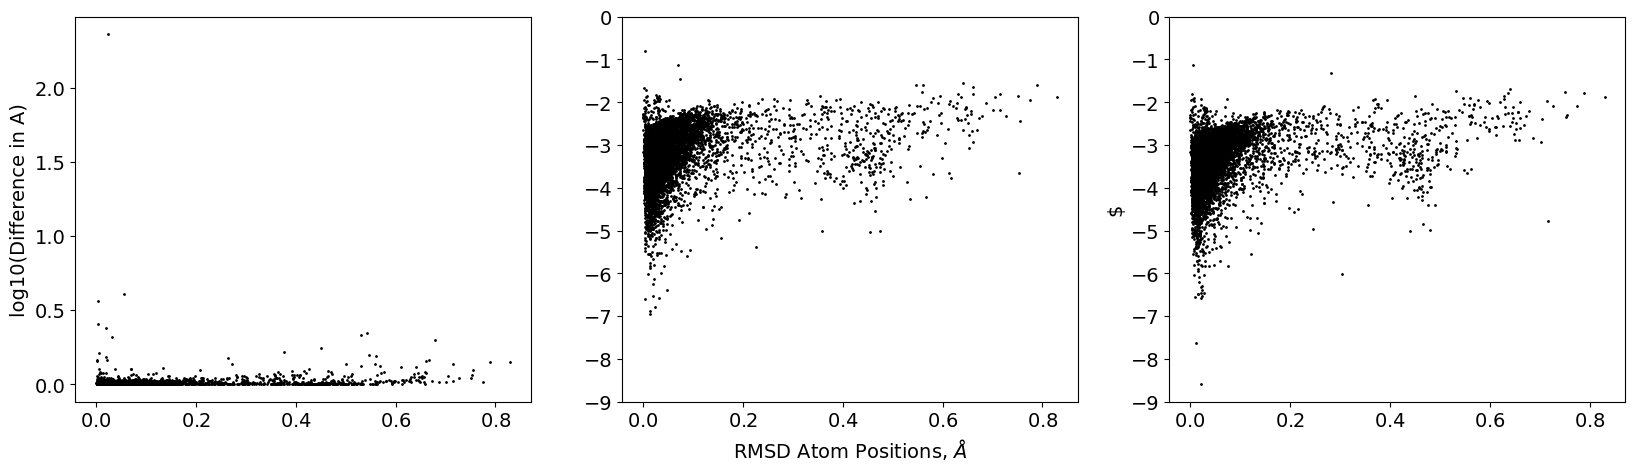

In [665]:
fig, ax = plt.subplots(1,3,figsize=(20,5),sharex = True)
ax[0].xaxis.major.formatter._useMathText = True

ax[0].plot(RMSD_A,Diff_A,'ko',markersize=1)
ax[0].set_ylabel(r'log10(Difference in A)',fontsize=14)
ax[0].xaxis.set_tick_params(labelsize=14)
ax[0].yaxis.set_tick_params(labelsize=14)



ax[1].plot(RMSD,np.log10(Diff_B),'ko',markersize=1)
ax[1].set_xlabel(r'RMSD Atom Positions, $\AA$',fontsize=14)
ax[1].set_ylabel(r'',fontsize=14)
ax[1].xaxis.set_tick_params(labelsize=14)
ax[1].yaxis.set_tick_params(labelsize=14)
ax[1].set_ylim([-9,0])

ax[2].plot(RMSD,np.log10(Diff_C),'ko',markersize=1)
ax[2].set_ylabel(r'$',fontsize=14)
ax[2].xaxis.set_tick_params(labelsize=14)
ax[2].yaxis.set_tick_params(labelsize=14)
ax[2].set_ylim([-9,0])


plt.show()